<a href="https://colab.research.google.com/github/98bao/Migros/blob/main/code/Project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DMML2020 - Project
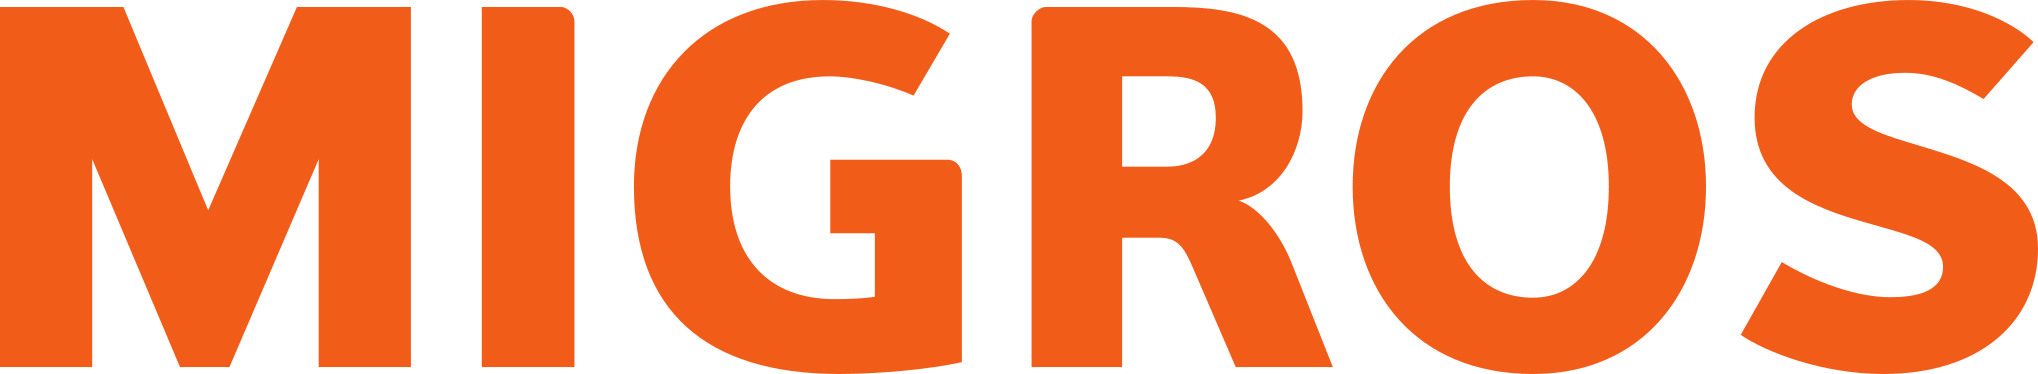
##Classification problem
In this project we analyze the data to know if a tweet is about a real disaster (target = 1) or not (target = 0).
A detailed description of the course of action can be found in the file Report.

---



# Importing useful tools 🧰

In [2]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [3]:
#clear output
%%capture 
# Install and update spaCy
!pip install -U spacy
!python -m spacy download en

In [44]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [45]:
#Importing useful extensions
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import spacy

from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from gensim.parsing.preprocessing import remove_stopwords

# Importing the project dataframes in the notebook 📚
In the following cells, we import some raw dataframes that we are going to use for the project

In [7]:
#Reading the dataframe to build our model
df_train = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/training_data.csv")
df_train.head(5)


,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1


In [12]:
#Reading dataframe which is going to be tested
df_test = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/test_data.csv")
df_test.head(5)

,id,keyword,location,text
0,9972,tsunami,NaN,Crptotech tsunami and banks.\n http://t.co/KHz...
1,9865,traumatised,"Portsmouth, UK",I'm that traumatised that I can't even spell p...
2,1937,burning%20buildings,NaN,@foxnewsvideo @AIIAmericanGirI @ANHQDC So ... ...
3,3560,desolate,NaN,Me watching Law &amp; Order (IB: @sauldale305)...
4,2731,crushed,bahstun/porta reeko,Papi absolutely crushed that ball


In [14]:
#Reading the sample submission
sample_submission = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/sample_submission.csv")

# Exploratory data analysis 🕵️

In the following cells, we explore the train dataset which we will be using to build a model. the subsection will describe the attributes listed below:

* Dataframe description   
* Base rate 
* Location 
* Keywords
* Text 


## Data description 

Short description to have an estimate the dataframe we will be using.

In [17]:
#shape of data 
print("Shape of data:", df_train.shape)
print ("Number of Rows:", df_train.shape[0])
print ("Number of Columns", df_train.shape[1])

Shape of data: (6471, 5)
Number of Rows: 6471
Number of Columns 5


In [18]:
#Name of columns
df_train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [16]:
#Sample of the column 'text' which will be analyzed
print("Train set sample:", df_train['text'].sample().values[0])
print("Test set sample:", df_test['text'].sample().values[0])

Train set sample: Lately I been stressing make me wanna put a fuck nigga on a stretcher!
Test set sample: disinfo: Warfighting Robots Could Reduce Civilian Casualties So Calling for a Ban Now Is ... -... http://t.co/yUinMErQ2s #criticalmedia


In [19]:
#Null values 
df_train.isnull().sum()

id             0
keyword       55
location    2141
text           0
target         0
dtype: int64

## Base rate
An indication of how often the most common value appears in the dataframe. We have to obtain an accuracy that is superior to the base rate to say that our classifier is well made.

In [20]:
#Number of tweets in df_train  that support or not a real disaster 
Tweets_support = len(df_train[df_train['target'] == 1])
Tweets_does_not_support = len(df_train[df_train['target'] == 0])
print("Number of tweets that does not support a real disaster : ", Tweets_does_not_support)
print("Number of tweets that support a real disaster:", Tweets_support)

Number of tweets that does not support a real disaster :  3701
Number of tweets that support a real disaster: 2770


In [21]:
#Base rate of the train df
r = df_train['target'].value_counts() /len(df_train) 
print("Base rate =", max(r))

Base rate = 0.5719363313243703


## Location

Exploration about the location in this dataset. There are 2922 different location present in the train set.

In [ ]:
df_train['location']

In [22]:
#Location null values
df_train.location.isnull().sum()

2141

In [23]:
# Number of location
loc_len =len(df_train['location'].unique())
print("Number of locations:", loc_len)

Number of locations: 2922


## Keywords

Following some information about the attribute keyword. There are 222 different keywords available in this dataset.

In [ ]:
df_train['keyword']

In [24]:
#Location null values
df_train.keyword.isnull().sum()

55

In [26]:
#Number of keywords
key_len = len(df_train['keyword'].unique())
print("Number of keywords:", key_len)


Number of keywords: 222


## Text
In this section we first present some general information about the attribute text. We then explore the words in the tweets more in detail.



In [35]:
#Total number of words in the train set
print("Total Number of Words in train set:", df_train['text'].apply(lambda x: len(x.split(' '))).sum())

#Total number of words in the test set
print("Total Number of Words in test set:", df_test['text'].apply(lambda x: len(x.split(' '))).sum())

Total Number of Words in train set: 96544
Total Number of Words in test set: 17110


In [36]:
#Check duplicates 
print('Entire Duplicated rows:', df_train.duplicated().sum())
print('Duplicated Text:', df_train['text'].duplicated().sum())
print('Duplicated Keywords:', df_train['keyword'].duplicated().sum())
print('Duplicate Locations:', df_train['location'].duplicated().sum())

Entire Duplicated rows: 0
Duplicated Text: 84
Duplicated Keywords: 6249
Duplicate Locations: 3549


In [37]:
#Column Text grouped by target in the train set (real disaster = 1)
df_train_grouped =df_train[['target','text']].groupby(by='target').agg(lambda x: ' '.join(x))
corpus = df_train_grouped['text']
corpus0 = corpus[[0]]
corpus1 = corpus[[1]]
print(corpus)

target
0    Black Eye 9: A space battle occurred at Star O...
1    Reality Training: Train falls off elevated tra...
Name: text, dtype: object


In [38]:
#Number of tweets about a real disaster and number of fake tweets
print("Number of tweets not about a real disaster:", corpus0.apply(lambda x: len(x.split(' '))).sum())
print("Number of tweets about a real disaster:", corpus1.apply(lambda x: len(x.split(' '))).sum())

Number of tweets not about a real disaster: 54373
Number of tweets about a real disaster: 42171


The following barcharts shows most common words in Tweets. This analisis can help us finding words which are very frequent in whole Tweets but that do not give much information for the Classification. The first thing that we can notice is that most frequent words are Stopwords, this kind of words do not give information so the have to be removed. Second thing that can be noticed are words like "ù_" "http" "https" "amp" or "co" that are extremely frequent in the database but did not give much information quite the opposite they represent disturbance, for that reason they have to be removed in order to improve accuracy results. 

In [40]:
#Function that find most common words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [41]:
Whole_tweets_most_common_words = get_top_n_words(corpus, 35)
Tweets_0_most_common_words = get_top_n_words(corpus0, 35)
Tweets_1_most_common_words = get_top_n_words(corpus1, 33)
print("Corpus:", Whole_tweets_most_common_words)
print("Corpus 0 :", Tweets_0_most_common_words)
print("Corpus 1 :", Tweets_1_most_common_words)
df =  pd.DataFrame(Whole_tweets_most_common_words, columns= ['Token', 'Frequency'])
df1 = pd.DataFrame(Tweets_1_most_common_words, columns= ['Token', 'Frequency'])
df0 = pd.DataFrame(Tweets_0_most_common_words, columns= ['Token', 'Frequency'])

Corpus: [('co', 4038), ('http', 3663), ('the', 2755), ('in', 1687), ('to', 1649), ('of', 1547), ('and', 1189), ('is', 811), ('you', 769), ('for', 754), ('on', 736), ('it', 658), ('my', 597), ('that', 521), ('with', 496), ('by', 465), ('at', 451), ('this', 402), ('https', 355), ('from', 354), ('are', 341), ('be', 335), ('was', 333), ('have', 329), ('û_', 295), ('amp', 294), ('like', 290), ('me', 287), ('as', 283), ('just', 282), ('up', 278), ('but', 275), ('so', 271), ('not', 253), ('your', 253)]
Corpus 0 : [('co', 1892), ('http', 1645), ('the', 1600), ('to', 998), ('and', 762), ('of', 754), ('in', 700), ('you', 642), ('is', 513), ('my', 479), ('it', 454), ('for', 416), ('on', 370), ('that', 345), ('with', 333), ('this', 248), ('https', 239), ('be', 235), ('me', 233), ('by', 219), ('have', 207), ('so', 206), ('like', 206), ('just', 204), ('are', 201), ('your', 198), ('at', 195), ('was', 189), ('but', 188), ('amp', 176), ('can', 174), ('not', 173), ('out', 169), ('up', 166), ('all', 165)

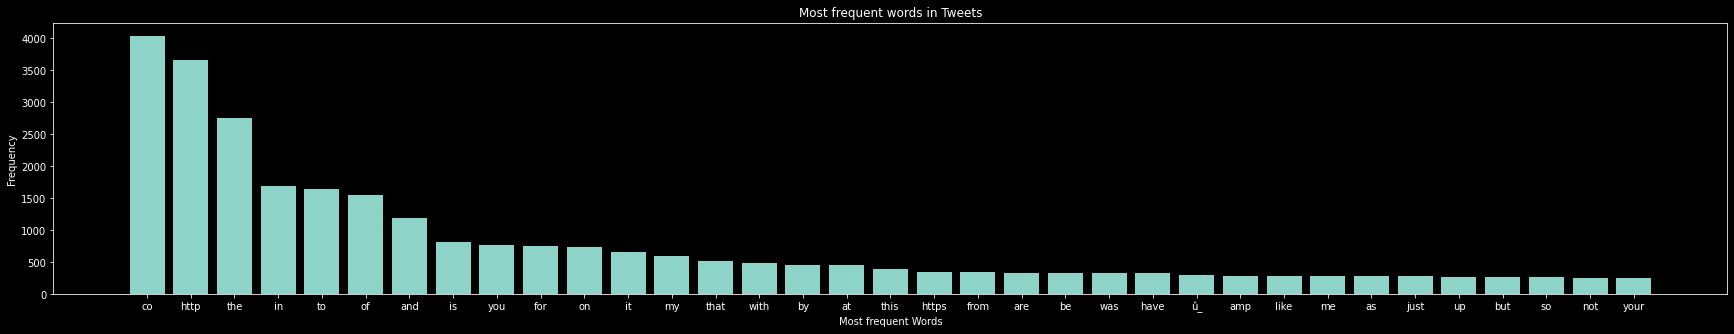

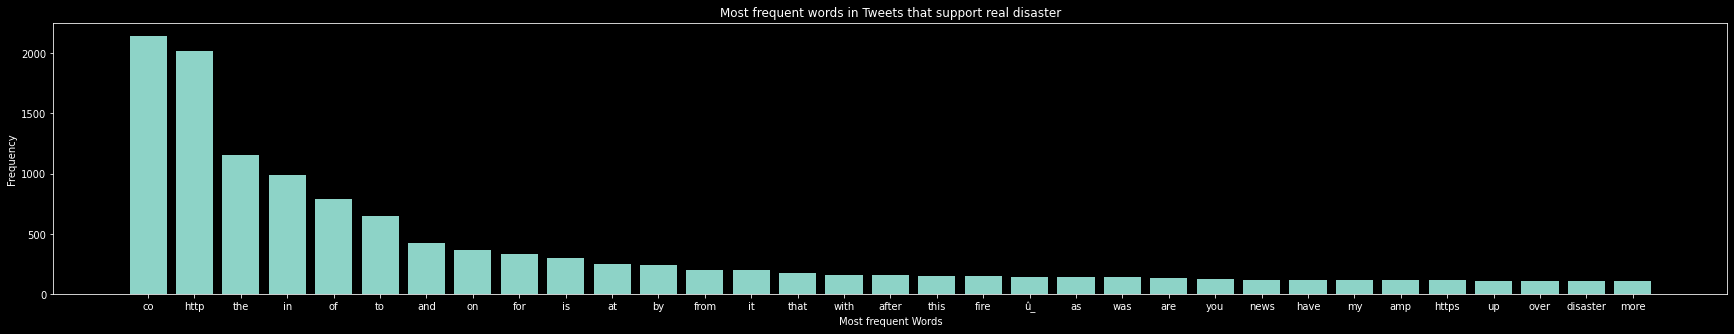

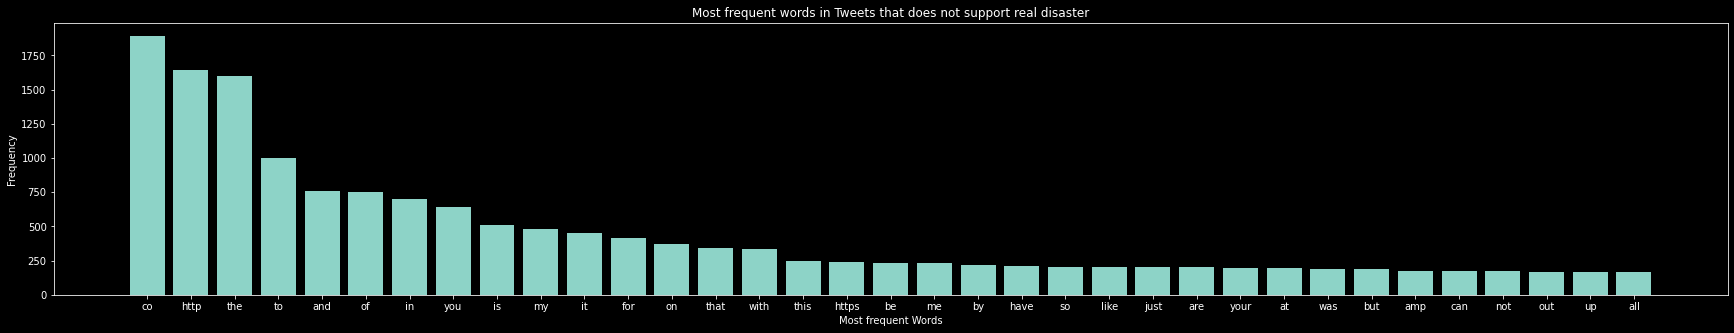

In [42]:
#Most frequent 10 words in tweets that support real disaster 
def barchart_most_frequent_words(data, title):
    plt.style.use('dark_background')
    token= data['Token']
    frequency = data['Frequency']
    plt.bar(token, frequency)
    plt.title(title)
    plt.xlabel('Most frequent Words')
    plt.ylabel('Frequency')
    return plt.show()

plt.rcParams['figure.figsize']= (30, 5)
# Barchart Most important word 
barchart_most_frequent_words(df, 'Most frequent words in Tweets')
barchart_most_frequent_words(df1, 'Most frequent words in Tweets that support real disaster')
barchart_most_frequent_words (df0, 'Most frequent words in Tweets that does not support real disaster')

# Building the tokenizer 🤖
In the following part, we create our tokenizer which will be used to analyze the text column.

In [43]:
#Create Tokenizer

#Stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS
#Punctuation
punctuations = string.punctuation

sp = spacy.load('en_core_web_sm')

#Tokenizer function
def spacy_tokenizer(sentence):
  mytokens = sp(sentence)

  #Lemmatize each token and convert each token into lowercase
  mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]  
  #Remove stop words and punctuation
  mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
  #Remove words with two letters or less
  mytokens = [ word for word in mytokens if len(word)>2 ]   
  #Return preprocessed list of tokens
  return mytokens

#demo
review = df_train["text"].sample()
demo = spacy_tokenizer(review.values[0])
demo

['dog', 'attack', 'food', 'pugprob']

To improve the token, we tried to stemm the words with the following code snippet:

    ps = PorterStemmer()
    stemmed_words = [ps.stem(w)for w in mytokens]
    lemmatizer = WordNetLemmatize()
    lemma_words = [lemmatizerlemmatize(w, pos='a')for w in stemmed_words]

Soon we realized that it did not improve the accuracy, so we removed it from the tokenizer function.

# Logistic regression and pipeline before data cleaning 

Our first iteration of the model: *No treatement of the dataframe*, just fitted in a logistic regression to see the result. We submitted this first try on AICrowd to check the accuracy of an uncleaned database.


In [46]:
#Setting up the train test split

#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
#TF-IDF feature vector
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

In [48]:
#Linear reg
LR = LogisticRegression(solver="lbfgs", max_iter=100)

#pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])

In [49]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...,
                                 tokenizer=<function spacy_tokenizer at 0x7fe7c4341ae8>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_i

## Accuracy

In [50]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.8937
CONFUSION MATRIX:
[[2882   79]
 [ 471 1744]]


In [51]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7884
CONFUSION MATRIX:
[[656  84]
 [190 365]]


## Using keywords only
This is a test to see if using only the keywords would give a good accuracy

In [52]:
#Replace null value by an arbitrary string
df_train.keyword.fillna(value = 'nokeyword', inplace = True)

#Verify
df_train.keyword.isnull().sum()

0

In [53]:
#Using keyword in the model
features = ['keyword', 'text']

X = df_train['keyword']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [54]:
#Linear reg
LR = LogisticRegression(solver="lbfgs", max_iter=100)

#pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])


In [55]:
#Fit
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...,
                                 tokenizer=<function spacy_tokenizer at 0x7fe7c4341ae8>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_i

In [56]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TRAIN ACCURACY SCORE:
0.7361
CONFUSION MATRIX:
[[2374  587]
 [ 779 1436]]
TEST ACCURACY SCORE:
0.7174
CONFUSION MATRIX:
[[583 157]
 [209 346]]


# Data cleaning 🧼
To further improve the accuracy of our model, we cleaned the text column by removing unecessary elements such as URL, Tags and noise.

In [57]:
#Need to replace NaN values by blank spaces otherwise some funtions wont run
df_test['text'] = df_test['text'].replace(np.nan, '')

In [60]:
#Clean duplicates
df_train =  df_train.drop_duplicates(subset=['text'], keep='first')

#replacing "%20" with space
df_train['keyword'] = df_train['keyword'].replace('%20', ' ', regex = True)
df_train['text'] = df_train['text'].replace('%20', ' ', regex = True)
df_test['keyword'] = df_test['keyword'].replace('%20', ' ', regex = True)
df_test['text'] = df_test['text'].replace('%20', ' ', regex = True)


#removing twitter tags
def remove_tags(text):
  text = re.sub(r'@\S+','',text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_tags(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_tags(x))


#removing hashtags
def remove_hash(text):
  text = re.sub('#','',text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_hash(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_hash(x))


#removing amp
def amp(text):
  text = re.sub('&amp;', '', text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: amp(x))
df_test['text'] = df_test['text'].apply(lambda x: amp(x))


#removing url
def remove_url(text):
  text = re.sub(r'http\S+', '', text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: remove_url(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_url(x))


#removing other noises
def remove_noise(text):
  text = re.sub('RT ', '', text)
  text = re.sub(' co ', '', text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_noise(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_noise(x))


#Remove other strange characters noise
def remove_noise_1(text):
  text = re.sub(' & ', '', text)
  text = re.sub(' û_ ', '',text)
  text = re.sub(' û ', '', text)
  text = re.sub('&', '', text)
  text = re.sub('©', ' ', text)
  text = re.sub('', '', text)
  text = re.sub('ª', '', text)
  text = re.sub(' ûªs ', '',text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_noise_1(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_noise_1(x))


#Remove multiple spaces and spaces from Start and End 
def remove_multiple_spaces(text):
  text = re.sub(r"\s+"," ", text, flags = re.I)
  text = re.sub(r"^\s+", "", text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_multiple_spaces(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_multiple_spaces(x))


#Remove uppercase character
def remove_uppercase(text):
   text = text.lower()
   return text
df_train['text'] = df_train['text'].apply(lambda x: remove_uppercase(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_uppercase(x))


#Remove single charachters
def remove_single_characters(text):
   text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
   return text

df_train['text'] = df_train['text'].apply(lambda x: remove_single_characters(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_single_characters(x))

While cleaning the dataset we realized, that too much cleaning can lead to information loss and therefore worsen the accuracy. 

The following text cleaning methods lead in our case to worse accuracy:

* Number:

  Removing all the numbers makes prediction worse. That could be because of dates and ages which provides usefull information to the machine learning algorithm. 
```
# remove digits
def remove_digits(text):
  text = re.sub(r"\d", "", text)
  return text
df_train['text'] = df_train['text'].apply(lambda x: remove_digits(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_digits(x))
```

* Stopwords:

  Since stopwords are removed in the tokenizer function, it does not necessarily improve the accuracy.
```
# Remove Stopwords
def remove_stopword(text):
  text= remove_stopwords(text)
  return text
df_train['text'] = df_train['text'].apply(lambda x: remove_stopword(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_stopword(x))
```

* Punctuation:

  Same as stopword, punctuation will be removed in the tokenizer function.
```
#removing punctuation
def remove_punct(text):
  text = "".join([char for char in text if char not in string.punctuation])
  text = re.sub(r"[0-9]+", "", text)
  return text
df_train['text'] = df_train['text'].apply(lambda x: remove_punct(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_punct(x))
```

# Logistic regression and pipeline after data cleaning 

Our second iteration of the model: *treatement of the dataframe with text cleaning*, fitted in a logistic regression to see the result.


In [62]:
#Setting up the train test split
#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [63]:
#TF-IDF feature vector
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

In [64]:
#Linear reg
LR = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72)

#pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])

In [65]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...',
                                 tokenizer=<function spacy_tokenizer at 0x7fe7c4341ae8>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_

## Accuracy

In [66]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.8869
CONFUSION MATRIX:
[[2714   69]
 [ 465 1475]]


In [67]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7959
CONFUSION MATRIX:
[[635  81]
 [160 305]]


# Using different classifiers 👨‍💻

We tried different classifier to know which one could predict the best our model.

We tried the methods below:
* Random forest classifier
* Doc2Vec

## Random forest classifier

According to the documentation, the RFC looks like the most fitting classifier for our case. Thus we allocated a lot of ressources to improve its accuracy: in the section below there is a take on parameters tuning for RFC.

In [68]:
from sklearn.ensemble import RandomForestClassifier

In [69]:
#Setting up the train test split

#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [74]:
#Define classifier
RFC = RandomForestClassifier(n_estimators = 16,max_depth = 60,random_state =72)
#Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', RFC)])

In [75]:
#Fit
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=60, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,


#### Accuracy

In [76]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.8374
CONFUSION MATRIX:
[[2776   11]
 [ 757 1179]]


In [77]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7409
CONFUSION MATRIX:
[[664  48]
 [258 211]]


#### Plot

We tried to plot different values of parameters to find the optimal one.

In [93]:
#packages needed for graphs
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

* n_estimator

In [ ]:
#Create array of values for n_estimators
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

#Build function to test value of array in the model
train_results = []
test_results = []
for estimator in n_estimators:
   RFC = RandomForestClassifier(n_estimators=estimator, n_jobs=-1) 
   pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', RFC)])
   pipe.fit(X_train, y_train)
   #Training data curve
   train_pred = pipe.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   #Test data curve
   y_pred = pipe.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)


In [ ]:
#Plotting the curves for train and test accuracy
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()
#We can see below a maximum for is between [25;50]

* max_depth

In [ ]:
#Tune max_depths parameters, analyze value between 1 and 100
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
#Creating a function
for max_depth in max_depths:
   RFC = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   
   pipe.fit(X_train, y_train)
   
   #Train data curve
   train_pred = pipe.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   #Test data curve
   y_pred = pipe.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

In [ ]:
#Plotting the curves for train and test accuracy
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

* min_samples_split

In [ ]:
#Want to know what values between 10% or 100% of the samples is needed
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
#the function
for min_samples_split in min_samples_splits:
   RFC = RandomForestClassifier(min_samples_split=min_samples_split)
   #Train data curve
   pipe.fit(X_train, y_train)
   train_pred = pipe.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   #Test data curve
   y_pred = pipe.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

In [ ]:
#Plotting the curves for train and test accuracy
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

* max_features

In [ ]:
#nb of features to consider when looking for the best split
max_features = list(range(1,df_train.shape[1]))
train_results = []
test_results = []
#the function
for max_feature in max_features:
   RFC = RandomForestClassifier(max_features=max_feature)   
   pipe.fit(x_train, y_train)
   #Train data curve
   train_pred = pipe.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   #Test data curve
   y_pred = pipe.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

In [ ]:
#Plotting the curves for train and test accuracy
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r, label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

## Doc2Vec

Since DOc2Vec focus on the context, we tried to use the DOc2Vec classifier instead of TF-IDF.

In [81]:
#packeges needed for DOc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

In [82]:
#First we need to tokenize the data
sample_tagged = df_train.apply(lambda r: TaggedDocument(words=spacy_tokenizer(r['text']), tags=[r.target]), axis=1)

#Setting up the train test split
train_tagged, test_tagged = train_test_split(sample_tagged, test_size=0.2, random_state=1234)

In [83]:
#Defining Doc2Vec and build vocabulary
model_dbow = Doc2Vec(dm=0, vector_size=30, negative=6, hs=0, min_count=1, sample=0, workers=cores, epoch=300)
model_dbow.build_vocab([x for x in train_tagged.values])

In [84]:
#Select X and y
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=100)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [85]:
#Fit
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Accuracy

In [86]:
#Accuracy of the train data
y_pred_train = logreg.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.5939
CONFUSION MATRIX:
[[2805    0]
 [1918    0]]


In [88]:
#Accuracy of the test data
y_pred_test = logreg.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.5876
CONFUSION MATRIX:
[[694   0]
 [487   0]]


#### Plot

In [90]:
import seaborn as sns

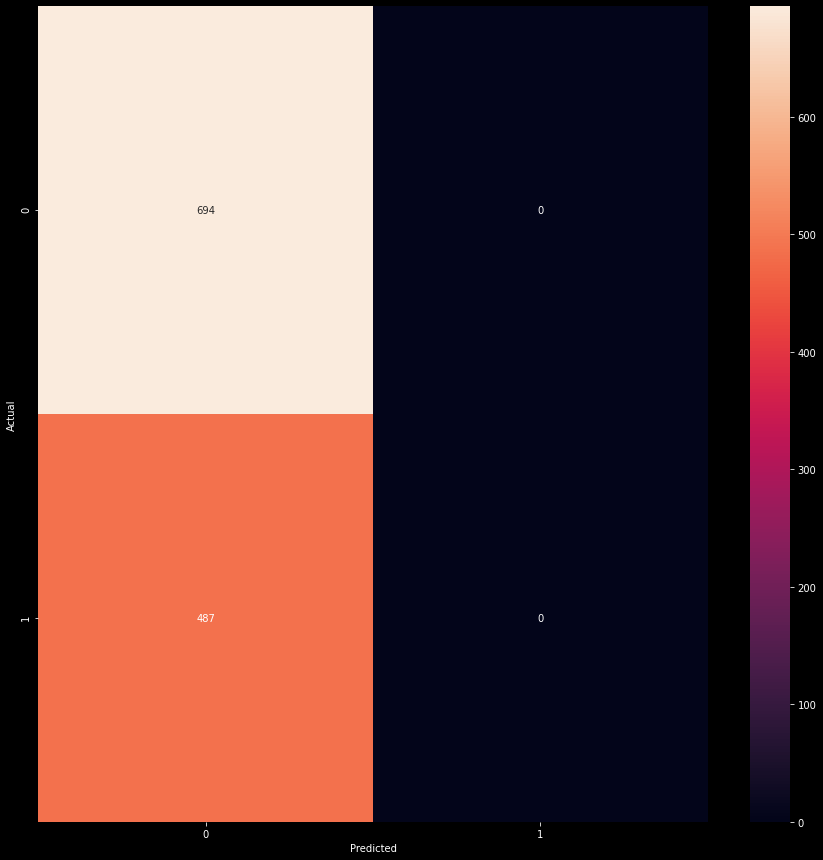

In [91]:
#heatmap for evaluation
conf_mat = confusion_matrix(y_test, y_pred_test)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Since Doc2Vec gives worse accuracy than TF-IDF classifier, we decided not to use this classifier anymore.